# R Exercises - part 5
- Name: Alberto Coppi
- Student ID: 2053063
- E-mail: <alberto.coppi@studenti.unipd.it>

## Import useful libraries

In [1]:
library(ggplot2)
library(gridExtra)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()



## Ex1 - Radioactive source

In [2]:
Dt  <- 10
obs <- c(4, 1, 3, 1, 3)

### a)
Assuming a flat prior the posterior of a Poisson process is the Gamma distribution $Gamma(\mu|\alpha, \lambda)$ with $\alpha=(\sum_{i=1}^n x_i) +1$ and $\lambda=n$ where ${x_i}$ is the set of observations and $n$ its magnitude.

In [3]:
u_alpha  <- sum(obs) + 1
u_lambda <- length(obs)

u_posterior <- function(mu) {dgamma(mu, shape=u_alpha, rate=u_lambda)}

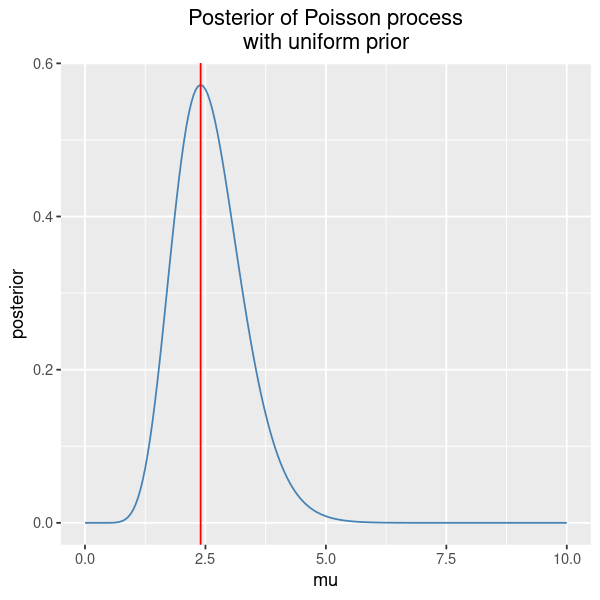

In [4]:
plot_pdf <- function(pdf, title) {
    mus <- seq(0, 10, length.out=201)

    options(repr.plot.width=5, repr.plot.height=5)
    plt <- ggplot(data.frame(mu=mus, posterior=pdf(mus)), aes(x=mu, y=posterior)) +
           geom_path(color='steelblue') +
           geom_vline(aes(xintercept=mu[which.max(posterior)]), color='red') +
           labs(title=title) +
           theme(plot.title=element_text(hjust=0.5))
    show(plt)
}

plot_pdf(u_posterior, 'Posterior of Poisson process\nwith uniform prior')

Now we calculate analitically and numerically the mean, median and variance. As the Gamma distribution has no analitical form to calculate the median, we calculate it using `qgamma`

In [5]:
u_mean.th   <- u_alpha/u_lambda
u_median.th <- qgamma(0.5, u_alpha, u_lambda)                              # alpha*(1-1/(9*alpha))^3
u_var.th    <- u_alpha/(u_lambda^2)

n_momentum <- function(n, pdf) {
    integrate(function(x) {x^n*pdf(x)}, lower=0, upper=Inf)[[1]]
}   

# experimental mean
u_mean.exp   <- n_momentum(1, u_posterior)

# experimental median
x <- 0
precision <- 10^-4
while(TRUE) {
    z <- integrate(u_posterior, lower=0, upper=x)[[1]]
    if(z>=0.5) break
    else x <- x+precision
}
u_median.exp <- x

# experimental variance
u_var.exp    <- n_momentum(2, u_posterior) - u_mean.exp^2

df <- data.frame(mean=c(u_mean.th, u_mean.exp), 
                 median=c(u_median.th, u_median.exp), 
                 variance=c(u_var.th, u_var.exp))
rownames(df) <- c('Analy.', 'Num.')
df

,mean,median,variance
,<dbl>,<dbl>,<dbl>
Analy.,2.6,2.533646,0.52
Num.,2.6,2.533700,0.52


### b)
Assuming a Jeffrey's prior the posterior of a Poisson process is the Gamma distribution $Gamma(\mu|\alpha, \lambda)$ with $\alpha=(\sum_{i=1}^n x_i) +\frac{1}{2}$ and $\lambda=n$ where ${x_i}$ is the set of observations and $n$ its magnitude.

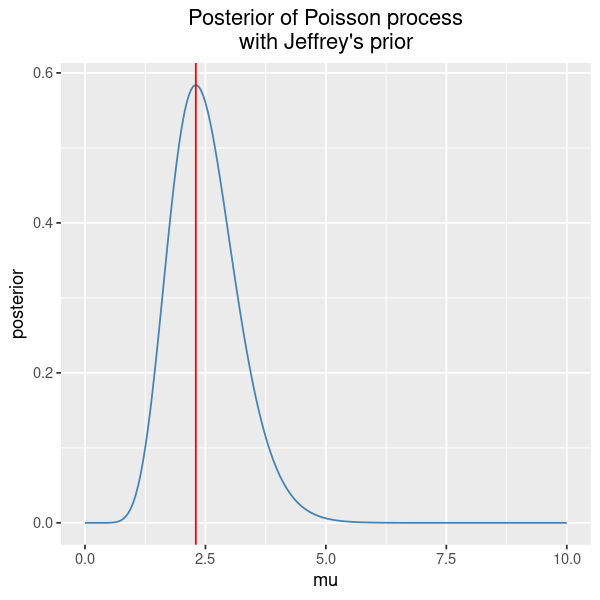

In [6]:
j_alpha  <- sum(obs) + 1/2
j_lambda <- length(obs)

j_posterior <- function(mu) {dgamma(mu, shape=j_alpha, rate=j_lambda)}

plot_pdf(j_posterior, "Posterior of Poisson process\nwith Jeffrey's prior")

In [7]:
j_mean.th   <- j_alpha/j_lambda
j_median.th <- qgamma(0.5, j_alpha, j_lambda)                              # alpha*(1-1/(9*alpha))^3
j_var.th    <- j_alpha/(j_lambda^2)

# experimental mean
j_mean.exp   <- n_momentum(1, j_posterior)

# experimental median
x <- 0
while(TRUE) {
    z <- integrate(j_posterior, lower=0, upper=x)[[1]]
    if(z>=0.5) break
    else x <- x+precision
}
j_median.exp <- x

# experimental variance
j_var.exp    <- n_momentum(2, j_posterior) - j_mean.exp^2

df <- data.frame(mean=c(j_mean.th, j_mean.exp), 
                 median=c(j_median.th, j_median.exp), 
                 variance=c(j_var.th, j_var.exp))
rownames(df) <- c('Analy.', 'Num.')
df

,mean,median,variance
,<dbl>,<dbl>,<dbl>
Analy.,2.5,2.433659,0.5
Num.,2.5,2.433700,0.5


### c)

In [8]:

confidence_interval <- function(mean, dist, ..., cl=0.95, precision=10^-4) {
    a <- mean
    b <- mean
    while (TRUE) {
        z <- integrate(dist, lower=a, upper=mean, ...)[[1]] +
             integrate(dist, lower=mean, upper=b, ...)[[1]]
        if(z > cl) break
        else if(a-precision >= 0) {
            if(a-precision >= 0) a <- a-precision
            b <- b+precision  
        }
        else b <- b+precision 
    }
    return(c(a, b))
}

In [9]:
cl=0.95

ci.unif <- confidence_interval(u_mean.th, u_posterior, cl=cl)
ci.jeff <- confidence_interval(j_mean.th, j_posterior, cl=cl)

ci.unif.norm <- c(qnorm( (1-cl)/2, mean=u_mean.th, sd=sqrt(u_var.th) ), 
                  qnorm( (1+cl)/2, mean=u_mean.th, sd=sqrt(u_var.th) ))
ci.jeff.norm <- c(qnorm( (1-cl)/2, mean=j_mean.th, sd=sqrt(j_var.th) ), 
                  qnorm( (1+cl)/2, mean=j_mean.th, sd=sqrt(j_var.th) ))


cat(sprintf("Posterior with uniform prior:\n\tMean\t\t: %.2f\n\t%i%% C.I.\t: %.4f - %.4f\n\tnorm approx.\t: %.4f - %.4f", 
    u_mean.th, cl*100, ci.unif[[1]], ci.unif[[2]], ci.unif.norm[[1]], ci.unif.norm[[2]]), '\n')
cat(sprintf("Posterior with Jeffrey's prior:\n\tMean\t\t: %.2f\n\t%i%% C.I.\t: %.4f - %.4f\n\tnorm approx.\t: %.4f - %.4f",
    j_mean.th, cl*100, ci.jeff[[1]], ci.jeff[[2]], ci.jeff.norm[[1]], ci.jeff.norm[[2]]), '\n')

Posterior with uniform prior:
	Mean		: 2.60
	95% C.I.	: 1.2146 - 3.9854
	norm approx.	: 1.1866 - 4.0134 
Posterior with Jeffrey's prior:
	Mean		: 2.50
	95% C.I.	: 1.1425 - 3.8575
	norm approx.	: 1.1141 - 3.8859 


## Ex2 - Lighthouse problem

To solve this problem we take into account the exercise done in class. The only difference is the fact that the parameter $\beta$ is not fixed. Thus, the analytical form of the likelihood remains unchanged, while the prior changes.  
In this case, given that $\alpha$ and $\beta$ are independent from each other we take a uniform prior for both of them. The analytical form is:
$
    P(\alpha, \beta) = \left\{ 
        \begin{array} {c l}
            \frac{1}{(\alpha_{max}-\alpha_{min})(\beta_{max}-\beta_{min})} & \quad \textrm{if } \alpha, \beta \in (\alpha_{min}, \alpha_{max})\times(\beta_{min}, \beta_{max})\\
            0                 & \quad \textrm{otherwise}
        \end{array}
        \right.
$

Be aware that this is a 2D distribution

In [180]:
alpha.min <- -6
alpha.max <- 6
beta.min  <- 10^-3
beta.max  <- 6
precision <- 10^-2
use_dcauchy <- FALSE

old.data     <- list()
evidenceEval <- list()

log.likelihood <- function( alpha, beta, data ) {
    l <- 0
    for( x in data ) {
        l <- l - log(beta^2 + (x-alpha)^2)          # log for more precise computation
    }
    return(l + log(beta)*length(data))
}

#likelihood <- function( alpha, beta, data ) {
#    l <- 1
#    for (x in data) {
#        l <- l*dcauchy(x, alpha, beta)
#    }
#    return(l)       
#}

evidence <- function( data ) {
    # check data in order to avoid useless recomputing
    n.data <- length(data)
    if(n.data > length(old.data) || 
       sum(data == old.data[[n.data]]) != length(old.data[[n.data]]) || 
       !length(old.data[[n.data]])) 
    {
        grid <- list(seq(alpha.min, alpha.max, by=precision), seq(beta.min, beta.max, by=precision))
        integral <- 0
        for(alpha in grid[[1]]) {
            for(beta in grid[[2]]) {
                y <- exp(log.likelihood( alpha, beta, data ))
                integral <- integral + y
            }
        }
        evidenceEval[[n.data]] <<- integral*precision^2  # we are integrating over a surface!
        old.data[[n.data]] <<- data
    }
    
    return(evidenceEval[[n.data]])
}

posterior <- function( alpha, beta, data ) {
    exp(outer(alpha, beta, FUN=log.likelihood, data)) / evidence(data)
}


In [181]:
plot_post <- function(data) {
    alpha <- seq(alpha.min, alpha.max, by=0.1)
    beta  <- seq(beta.min, beta.max, by=0.1)
    values <- posterior(alpha, beta, data)
    colnames(values) <- beta
    data2plot <- data.frame(values) %>% 
                 cbind(alpha) %>% 
                 pivot_longer(names_to='beta', values_to='post', -alpha) %>% 
                 mutate(beta=as.numeric(str_replace(beta, "X", ""))) 
    max.index <- which.max(data2plot$post)
    plt <- ggplot(data2plot, aes(x=alpha, y=beta, fill=post)) +
           geom_raster() + 
           geom_vline(xintercept=mean(data), linetype='dashed') +
           geom_point(data=data.frame(x=data, y=rep(-0.3, length(data))), 
                    mapping=aes(x=x, y=y), inherit.aes=FALSE , color='darkblue', fill='white', shape=21, stroke=2) +                                                   
           scale_fill_gradientn(colours=terrain.colors(10)) +
           labs(title=sprintf("N = %i", length(data))) +
           theme(plot.title=element_text(hjust=0.5), 
                 panel.grid.major = element_blank(), 
                 panel.grid.minor = element_blank(),
                 panel.background = element_blank(),
                 axis.line = element_line(colour = "black")) +
           annotate(geom='text', x=-3.5, y=4.4, 
                    label=sprintf("Max(Post):\nalpha = %.2f\nbeta = %.2f", 
                                  data2plot$alpha[[max.index]], 
                                  data2plot$beta[[max.index]]),
                    size=3) +
           coord_cartesian(xlim=c(alpha.min, alpha.max))
           
    return(plt)
}

In [182]:
# GENERATE DATA
set.seed(5678901)
n.data <- c(1, 2, 3, 5, 10, 20, 50, 100)
# fix true beta and alpha
alpha <- 1
beta  <- 1
theta <- runif(1000, 0, pi)
# calculate data
data <- beta*tan(theta) + alpha
#comment the line below to get an unbiased analysis
data <- data[(data>alpha.min) & (data < alpha.max)]
plts <- list()

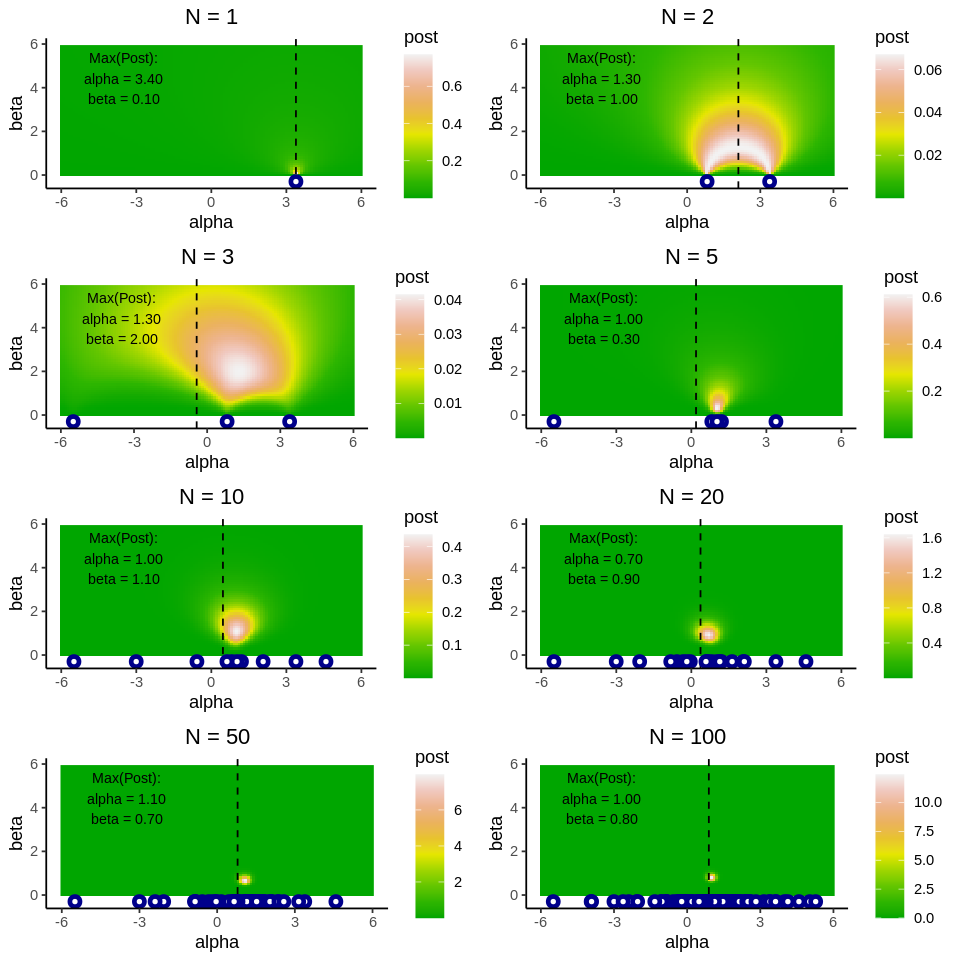

In [183]:
# GENERATE PLOTS
for (i in seq_along(n.data)) {
    plt <- plot_post(data[1:n.data[[i]]])
    plts[[i]] <- plt
}

options(repr.plot.width=8, repr.plot.height=8)
grid.arrange(grobs=plts, ncol=2)

Note that having imposed limits on the data we take into account, the analysis is a bit biased.  
Below the best estimate of the parameters with 95% C.L. C.I. is given:

In [33]:
confidence_interval <- function(mean, dist, ..., cl=0.95, precision=10^-4) {
    a <- mean
    b <- mean
    while (TRUE) {
        z <- integrate(dist, lower=a, upper=mean, ...)[[1]] +
             integrate(dist, lower=mean, upper=b, ...)[[1]]
        if(z > cl) break
        else {
            a <- a-precision
            b <- b+precision  
        }
    }
    return(c(a, b))
}

post.marginal.beta <- function(alpha, data) {
    sapply(alpha, function(alpha, data) {
        integrate(function(beta, alpha, data) {posterior(alpha, beta, data)},
                  lower=beta.min, upper=beta.max, alpha, data)[[1]]
    }, data)
}

post.marginal.alpha <- function(beta, data) {
    sapply(beta, function(beta, data) {
        integrate(posterior, lower=alpha.min, upper=alpha.max, beta, data)[[1]]
    }, data)
}



alpha.mode <- optimize(post.marginal.beta, lower=alpha.min, upper=alpha.max, maximum=TRUE, data=data[1:100])[[1]]
beta.mode  <- optimize(post.marginal.alpha, lower=beta.min, upper=beta.max, maximum=TRUE, data=data[1:100])[[1]]

ci.alpha <- confidence_interval(alpha.mode, post.marginal.beta, data[1:100], precision=10^-2)
ci.beta  <- confidence_interval(beta.mode, post.marginal.alpha, data[1:100], precision=10^-2)

cat(sprintf("Alpha:\n\tTrue: %.2f\n\tMode: %.2f\n\t%i%% C.I.: %.2f - %.2f", alpha, alpha.mode, 95, ci.alpha[[1]], ci.alpha[[2]]), '\n')
cat(sprintf("Beta:\n\tTrue: %.2f\n\tMode: %.2f\n\t%i%% C.I.: %.2f - %.2f", beta, beta.mode, 95, ci.beta[[1]], ci.beta[[2]]), '\n')

Alpha:
	True: 1.00
	Mode: 1.00
	95% C.I.: 0.76 - 1.24 
Beta:
	True: 1.00
	Mode: 0.79
	95% C.I.: 0.56 - 1.02 


## Ex3 - Signals analysis
### a) and b)

In [161]:
# - Generative model
signal <- function(x, a, b, x0, w, t) {
    t * (a*exp(-(x-x0)^2/(2*w^2)) + b)
}

# Define model parameters
x0 <- 0         # Signal peak
w <-1           # Signal width
A.true <- c(1, 1.5, 2, 3, 4)     # Signal amplitude
B.true <- c(4, 1.5, 1, 3, 1 )    # Background amplitude
Delta.t <- 5    # Exposure time
resolutions <- c(0.1, 0.25, 0.5, 1, 2, 3)

# - Generate the observed data
set.seed(205)
plts <- list()
datplt <- data.frame(x=NA, y=NA, resolution=NA, A=NA, B=NA)
data <- data.frame(x=NA, y=NA, resolution=NA, A=NA, B=NA)
data <- data[-1,]
datplt <- datplt[-1,]
for( i in seq_along(resolutions) ) {
    for( j in seq_along(A.true)) {
        xdat   <- seq(from=-7*w, to=7*w, by=resolutions[[i]]*w)
        s.true <- signal(xdat , A.true[[j]] , B.true[[j]] , x0, w, Delta.t)
        ddat   <- sapply(s.true, function(s) {rpois(1, s)})
        xplot  <- seq(from=min(xdat), to=max(xdat), by=0.05*w)
        splot  <- signal(xplot , A.true[[j]] , B.true[[j]] , x0, w, Delta.t)
        datplt <- rbind(datplt, data.frame(x=xplot, y=splot, 
                                        resolution=rep(resolutions[[i]], length(xplot)), 
                                        A=rep(A.true[[j]], length(xplot)),
                                        B=rep(B.true[[j]], length(xplot))))
        data   <- rbind(data, data.frame(x=xdat-resolutions[[i]]/2, y=ddat, 
                                        resolution=rep(resolutions[[i]], length(xdat)),
                                        A=rep(A.true[[j]], length(xdat)),
                                        B=rep(B.true[[j]], length(xdat))))
    }
}


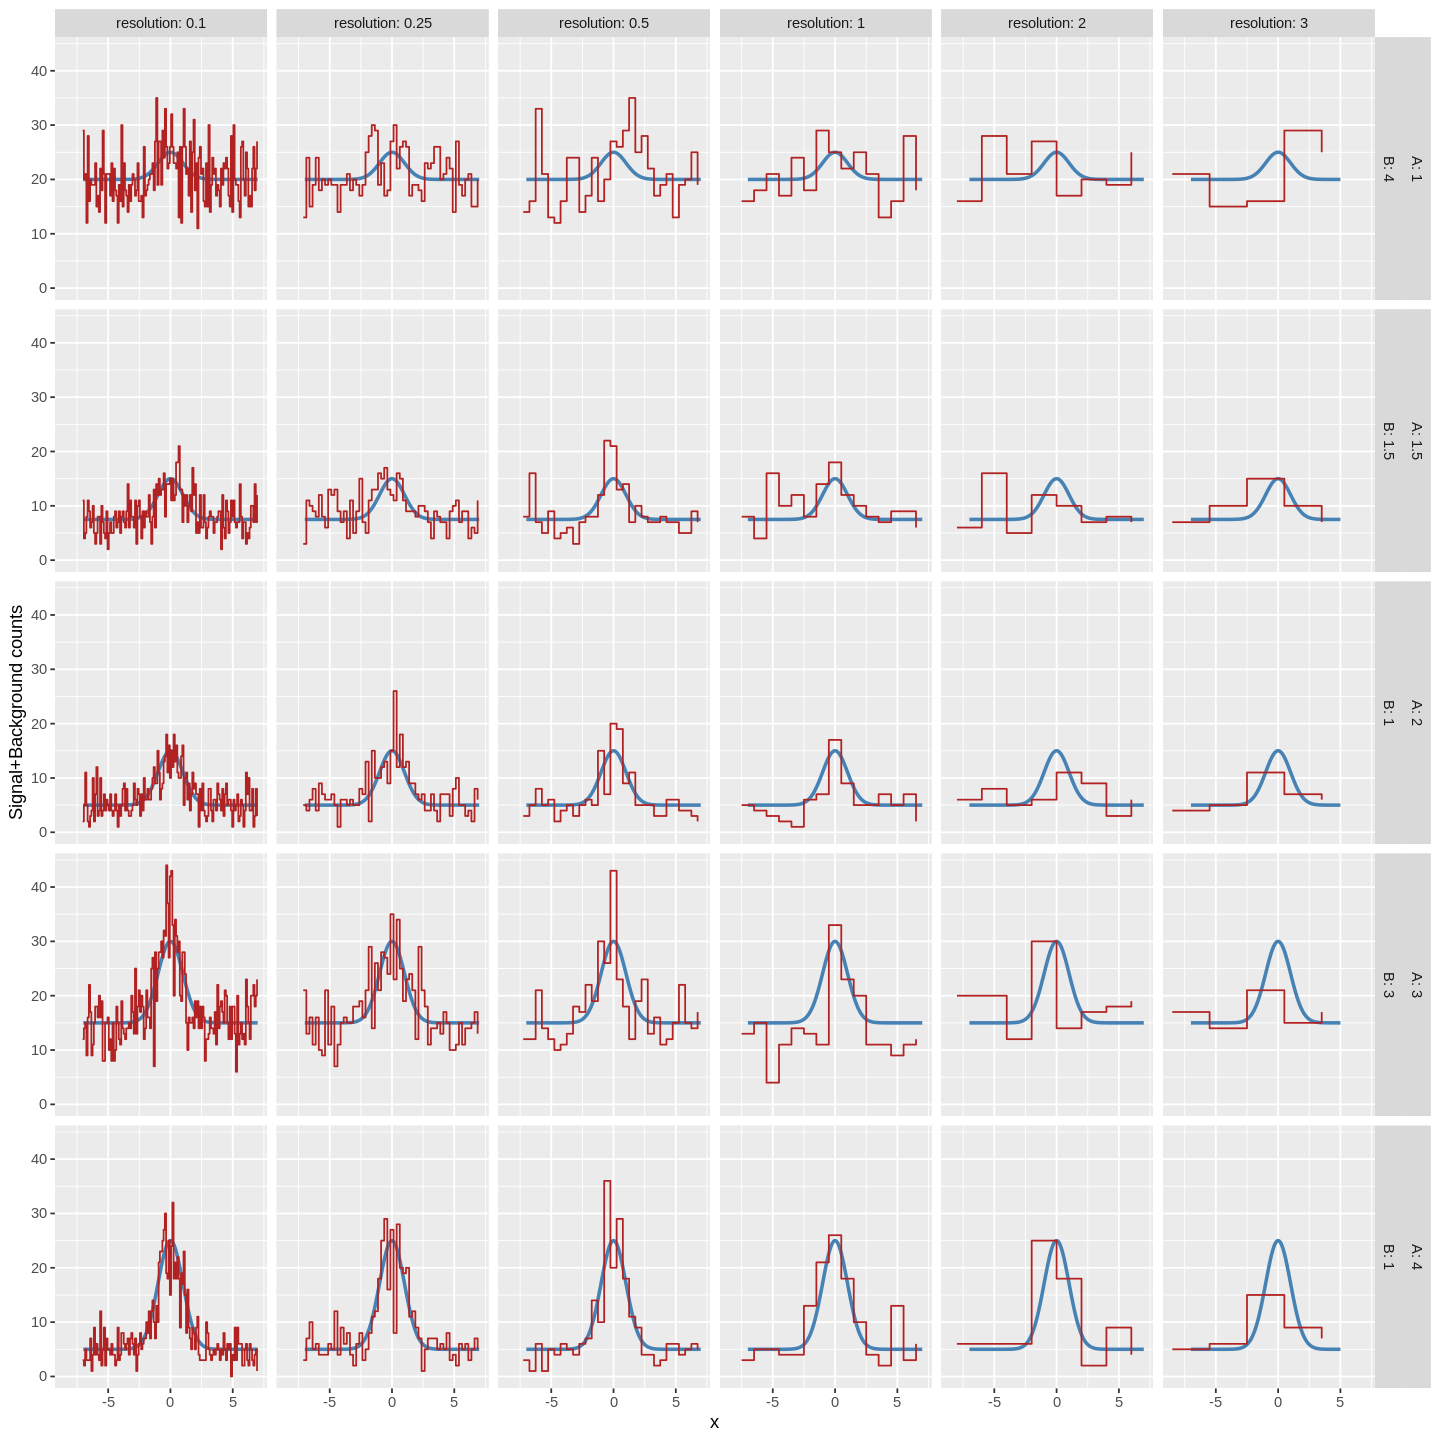

In [174]:
# plot data
options(repr.plot.height=12, repr.plot.width=12)
ggplot(mapping=aes(x=x, y=y)) +
geom_line(data=datplt, color='steelblue', size=1) +
geom_step(data=data, color='firebrick') +
labs( x='x', y='Signal+Background counts') +
facet_grid(A + B ~ resolution,labeller='label_both')

In [169]:
# - Sampling grid for computing posterior
alim <- c(0.0, 5.0)
blim <- c(0.1, 4.5)
Nsamp <- 100
uniGrid <- seq(from=1/(2*Nsamp), to=1-1/(2*Nsamp), by=1/Nsamp)
#delta_a <- diff(alim) / Nsamp
#delta_b <- diff(blim) / Nsamp
a <- alim[1] + diff(alim) * uniGrid
b <- blim[1] + diff(blim) * uniGrid

precision    <- 10^-1
old.data     <- list()
evidenceEval <- list()

# log posterior
log.post <- function(a, b, d, x, x0, w, t) {
    if(a<0 || b <0) {return(-Inf )} # the effect of the prior
    sum(mapply(dpois, d, lambda=signal(x, a, b, x0, w, t), log=TRUE))
}

evidence <- function( ddat, xdat ) {
    # check data in order to avoid useless recomputing
    n.data <- length(xdat)
    if(n.data > length(old.data) || 
       sum(xdat == old.data[[n.data]][[2]]) != length(old.data[[n.data]][[2]]) ||
       sum(ddat == old.data[[n.data]][[1]]) != length(old.data[[n.data]][[1]]) ||
       !length(old.data[[n.data]][[2]]))
    {
        grid <- list(seq(alim[[1]], alim[[2]], by=precision), seq(blim[[1]], blim[[2]], by=precision))
        integral <- 0
        for(alpha in grid[[1]]) {
            for(beta in grid[[2]]) {
                y <- exp(log.post( alpha, beta, ddat, xdat, x0, w, Delta.t ))
                integral <- integral + y
            }
        }
        evidenceEval[[n.data]] <<- integral*precision^2  # we are integrating over a surface!
        old.data[[n.data]] <<- list(ddat, xdat)
    }
    
    return(evidenceEval[[n.data]])
}

# posterior
posterior <- function(a, b, d, x, x0, w, t) {
    exp(outer(a, b, FUN=Vectorize(log.post, c("a", "b")), d, x, x0, w, t)) / evidence(d, x)
}


In [170]:
# Generate processed data
set.seed(205)
datproc <- data.frame(x=NA, y=NA, post=NA, resolution=NA, A=NA, B=NA)
datproc <- datproc[-1,]

for( i in seq_along(resolutions) ) {
    for( j in seq_along(A.true)) {
        xdat   <- seq(from=-7*w, to=7*w, by=resolutions[[i]]*w)
        s.true <- signal(xdat , A.true[[j]] , B.true[[j]] , x0, w, Delta.t)
        ddat   <- sapply(s.true, function(s) {rpois(1, s)})
        values <- posterior(a, b, ddat, xdat, x0, w, Delta.t)
        colnames(values) <- b
        tmp.df <- data.frame(values) %>% 
                cbind(a) %>% 
                pivot_longer(names_to='y', values_to='post', -a) %>% 
                mutate(y=as.numeric(str_replace(y, "X", ""))) 
        colnames(tmp.df)[[1]] <- 'x'
        tmp.df <- cbind(tmp.df, resolution=rep(resolutions[[i]], length(tmp.df$x)),
                        A=rep(A.true[[j]], length(tmp.df$x)),
                        B=rep(B.true[[j]], length(tmp.df$x)))
        
        datproc <- rbind(datproc, tmp.df)   
    } 
}

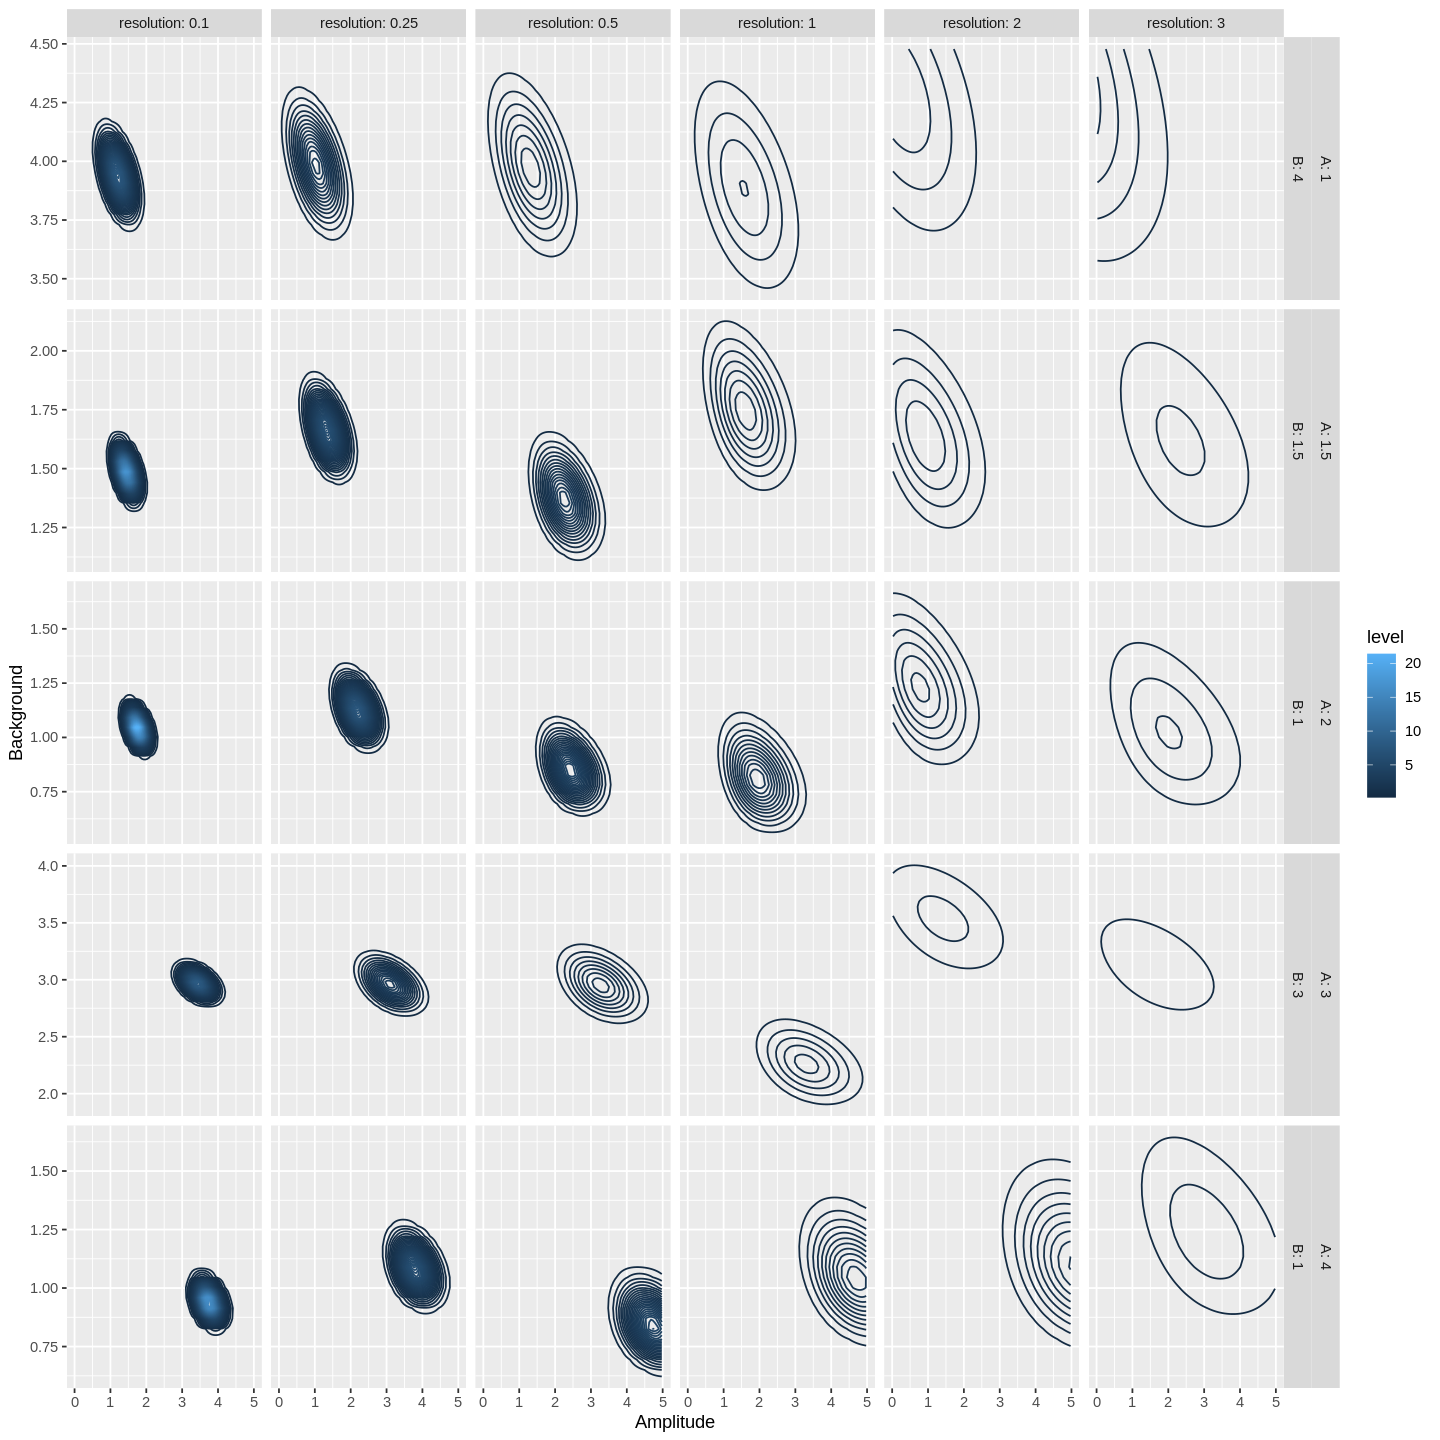

In [179]:
# plot processed data
options(repr.plot.height=12, repr.plot.width=12)
ggplot(data=datproc, mapping=aes(x=x, y=y, z=post, color=after_stat(level))) +
geom_contour(binwidth=0.2) +
labs( x='Amplitude', y='Background') +
facet_grid(A + B ~ resolution, labeller='label_both', scale='free_y')

We see that, in general, a better resolution leads to better results both in terms of expected value an credibility interval (the better the resolution the narrower the interval).  
Changing the ratio $\frac{A}{B}$ we can notice that the smaller the ratio, the greater the covariance of the two variables, as one would expect being B the noise.